# Определение возраста покупателей (компьютерное зрение)

**Заказчик:** сетевой супермаркет «Хлеб-Соль» 

**Описание:** компания внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы
* Контролировать добросовестность кассиров при продаже алкоголя

**Задача:** необходимо создать модель, которая по фотографии определит приблизительный возраст человека. Предоставлен набор фотографий людей с указанием возраста

## Исследовательский анализ данных

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, AvgPool2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# загружаем данные

datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)
features, target = next(datagen_flow)

**Вывод**
В данном датасете 7591 фото - я считаю, что 75% от этого числа (5 693 фото) достаточно для обучения, так как варианты целевого показателя ограничены (100 лет), получается приблизительно по 569 фото для 1 года (в хорошем случае). Однако далее будет известно, что данные распределены неравномерно и на людей старше 40 лет приходится менее 100 фото, но и этого может быть вполне достаточно, чтобы определять возраст целевой групы поупателей.


In [ ]:
print('Размер labels -', labels.shape)
print()
print(labels.info())
print()
print(labels['real_age'].describe())

Размер labels - (7591, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


**Распределения возрастов**


,count
real_age,
30,317
25,315
27,229
26,226
28,217


,count
real_age,
96,2
91,1
93,1
97,1
100,1


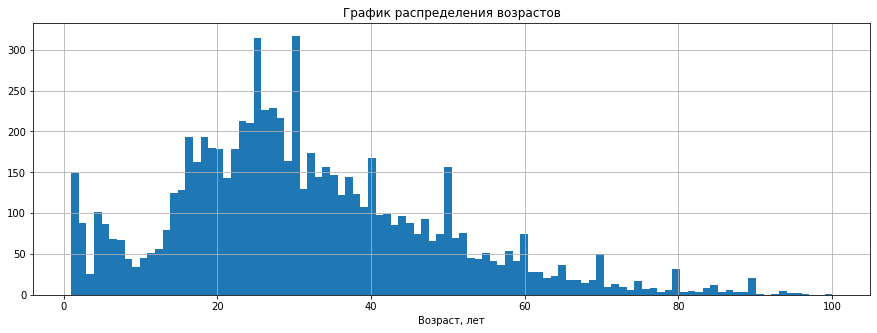

In [ ]:
pivot_real_age = labels.groupby('real_age')['real_age'].agg(['count'])
print('**Распределения возрастов**')
display(pivot_real_age.sort_values(by='count', ascending=False).head(5))
display(pivot_real_age.sort_values(by='count', ascending=False).tail(5))

plt.title('График распределения возрастов')
plt.xlabel('Возраст, лет')
(labels['real_age'].hist(bins=100, figsize=(15,5)))
# (pivot_real_age.plot(figsize=(20,5), grid=True));
plt.show()

**В данных 7591 значение возрастов. Наибольшее количество примеров людей 30летнего возраста (317 человек), далее идут 25летние (315 человек), 27летние (229 человек), 26летние (226 человек) и 28летние (217 человек). Наименьшее количество примеров людей от 90лет**

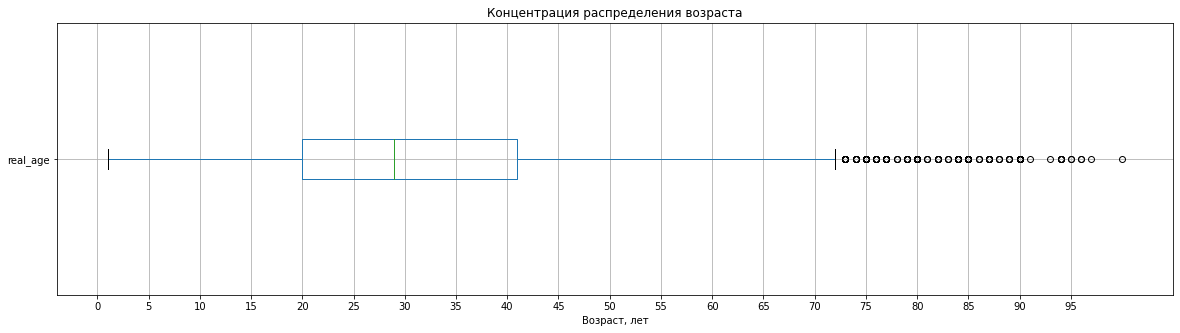

In [ ]:
labels.boxplot(column=['real_age'], figsize=(20,5), vert=False);
plt.xticks(np.arange(0, 100, 5.0))
plt.title('Концентрация распределения возраста')
plt.xlabel('Возраст, лет')
plt.show()

**Существуют значения свыше 76 лет, которые встречаются редко и считаются выбросами. Среднее значение - 31 год**

In [ ]:
print('Размер features', features.shape)
print('Размер target', target.shape)
print('Количество батчей в наборе данных', len(datagen_flow))

Размер features (32, 224, 224, 3)
Размер target (32,)
Количество батчей в наборе данных 238


**Таким образом, обучение модели будет происходить на цветных фото размером 224 на 224 пикселя, выборка поделена на множество слоёв по 32 изображения, количество батчей 238**

In [ ]:
# примеры 
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i+1])
    plt.title('Real Age {:.0f}'.format(target[i+1]))
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

![](https://i.postimg.cc/pLpdJkW4/image.png)

**Вывод:**

Представлены данные людей от 1 до 100 лет в количестве 7591 фото. Распределение норамльное с правым хвостом, основной объем фото людей в возрасте от 16 до 40 лет (так как в данном возрасте пик активности в социальных сетях). Средний возраст по выборке 31год.

Обучение модели будет происходить на цветных фото размером 224 на 224 пикселя, выборка поделена на множество слоёв по 32 изображения, количество батчей 238

## Обучение модели

```python

def load_train(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    
     train_datagen = ImageDataGenerator(validation_split=0.25,
                                  rescale=1/255,
                                       horizontal_flip=True,
                                   brightness_range=(0.8, 1.)
                                      )
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 
         
    return train_gen_flow
 
def load_test(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                  rescale=1/255
                                 )
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
         
    return test_gen_flow
 
 
 
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                 include_top=False,
                 weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5') 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
 
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
 
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-01-25 18:05:04.703280: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-01-25 18:05:05.115521: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 61s - loss: 277.9542 - mean_absolute_error: 11.7987 - val_loss: 833.6853 - val_mean_absolute_error: 23.9850
Epoch 2/10
178/178 - 52s - loss: 81.2608 - mean_absolute_error: 6.7603 - val_loss: 486.6123 - val_mean_absolute_error: 16.5342
Epoch 3/10
178/178 - 51s - loss: 51.4015 - mean_absolute_error: 5.4242 - val_loss: 187.4566 - val_mean_absolute_error: 10.3416
Epoch 4/10
178/178 - 51s - loss: 38.3567 - mean_absolute_error: 4.7020 - val_loss: 114.8923 - val_mean_absolute_error: 8.1735
Epoch 5/10
178/178 - 52s - loss: 28.8549 - mean_absolute_error: 4.1345 - val_loss: 87.1528 - val_mean_absolute_error: 7.1765
Epoch 6/10
178/178 - 51s - loss: 22.9393 - mean_absolute_error: 3.6348 - val_loss: 126.4322 - val_mean_absolute_error: 8.8203
Epoch 7/10
178/178 - 50s - loss: 19.5774 - mean_absolute_error: 3.3538 - val_loss: 70.9456 - val_mean_absolute_error: 6.4147
Epoch 8/10
178/178 - 52s - loss: 15.4581 - mean_absolute_error: 2.9777 - val_loss: 67.8800 - val_mean_absolute_error: 6.2681
Epoch 9/10
178/178 - 49s - loss: 11.8679 - mean_absolute_error: 2.6293 - val_loss: 70.4458 - val_mean_absolute_error: 6.2939
Epoch 10/10
178/178 - 48s - loss: 10.5877 - mean_absolute_error: 2.5063 - val_loss: 59.9680 - val_mean_absolute_error: 5.8228
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 59.9680 - mean_absolute_error: 5.8228
Test MAE: 5.8228

```

## Анализ обученной модели

Задача построить и обучить модель, которая поможет определять возраст человека по изображению с камеры. Среднее абсолютное отклонением MAE не должно превышать 7.

Данные были поделены на тренировочную выборку 75% фото и тестовую 25% фото.

В качестве основы за модель взяли уже предобученную нейросеть с архитектурой ResNet50 и дополнительно обучили её на предоставленных данных без замораживания. В выходном слое, для более точного обучения модели, использовали оптимизацию Adam c шагом обучения 0,0001, а в качестве функции потерь использовалась mean_squared_error, что немного ускорило процесс обучения.


С такими параметрами модель была протестирована на 10 эпохах, на 7 эпохе обучения на тестовых данных, модель достигла значения по метрике MAE равное 6.4147, что удовлетворяет условию (меньше 7). К 10 эпохе значение MAE уже составляет 5.8228 

Таким образом, поставленная задача по достижению требуемой точности предсказания возраста моделью была достигнута.

**Общие выводы**

* В качестве основы за модель взяли уже предобученную нейросеть с архитектурой ResNet50 и дополнительно обучили её на предоставленных данных без замораживания. 
* Для обучения было выбрано количество эпох равное 10, 238 батчей, использован оптимизатоор Adam с показателем lr=0.0001, также была применена аугментация - отражение по горизонтали и повышение яркости
*  Целевой показатель потерь (MAE) был достигнут - менее 7, с перебучением не столкнулись, так как MAE стабильно уменьшался с каждой эпохой
